### GW tutorial 3: Generation of data and matched filtering

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [2]:
!pip install pycbc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.7/168.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependency resolver

In [7]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd, pycbc.noise
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
import random

Previously, we have plotted the PSD of different detectors. Some PSDs are from previous runs (O3), while some others are the design sensitivity of future detectors.

The PSD characterizes the noise of the detector, so we can generate detector noise accordingly.

**Exercise 1:** Load the `aligo_O4high.txt` PSD to [generate](https://pycbc.org/pycbc/latest/html/pycbc.noise.html#pycbc.noise.gaussian.noise_from_psd) some Gaussian data.

_Hint:_ Minimum frequency is 10 Hz, sampling rate 4096 Hz and we want 20s of duration

In [11]:
# if running on colab make sure the file is uploaded in content
dataset = "aligo_O4high.txt" # load the dataset

[3.87463258e-21 4.85470892e-21 3.93475236e-21 ... 4.21740018e-21
 4.26629702e-21 4.20210254e-21]


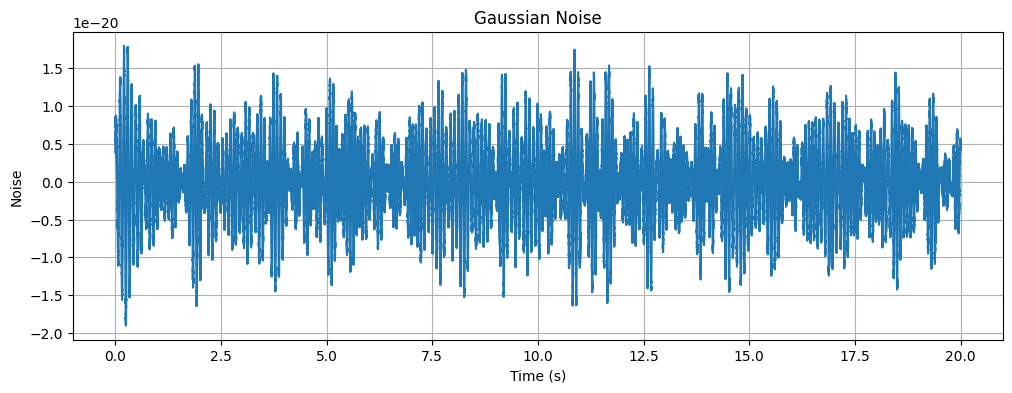

Gaussian noise length: 81920


In [19]:
# define given parameters
min_frequency = 10.2166 # minimal frequency detected (Hz)
sampling_rate = 4096 # Number of samples per second (Hz)
T = 20 # duration (seconds)

# define additional parameters
delta_f = 1/T # data resolution - lower delta_f means more precise measurements allowed by more time to measure (duration)
delta_t = 1/sampling_rate # time resolution - time between two samples (how often we do the measurement)
N_samples = sampling_rate * T
dataset_real_length = int((N_samples/2) + 1) # second half of the dataset are mirrored (negative) values from the first half

# read the PSD from our dataset
dataset_psd = pycbc.psd.read.from_txt(dataset, length=dataset_real_length, delta_f = delta_f, low_freq_cutoff=min_frequency)

# define Guassian noise
gauss_noise = pycbc.noise.gaussian.noise_from_psd(int(N_samples), delta_t, dataset_psd, seed = None)
print(gauss_noise)

# plot the Gaussian noise
plt.figure(figsize=(12, 4))
plt.plot(gauss_noise.sample_times, gauss_noise)
plt.title("Gaussian Noise")
plt.xlabel("Time (s)")
plt.ylabel("Noise")
plt.grid(True)
plt.show()

print("Gaussian noise length:", len(gauss_noise))


As you can see. the generated noise is "coloured" according to the detector noise. Now, we would like to add a simulated gravitational wave signal in our detector noise.

**Exercise 2:** Using [this function](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform) to generate waveforms in time domain, provide the plus and cross polarization of a binary black hole merger of $m_{1} = m_{2} = 50$ at 2000 Mpc. Use the waveform approximant "IMRPhenomD". How does the waveform amplitude compare to the detector noise?

The waveform comes from the source, but it needs to be projected in the detector. [Project](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector.project_wave) the waveform on LIGO Livingston (L1) at random sky-location and polarization. You can specify your detector with [this](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector) function. How does the waveform change because of this projection?

_Hint:_ Right ascension range is $[0, 2\pi]$, declination is $[-2\pi, 2\pi]$ and polarization is $[0, 2\pi]$.

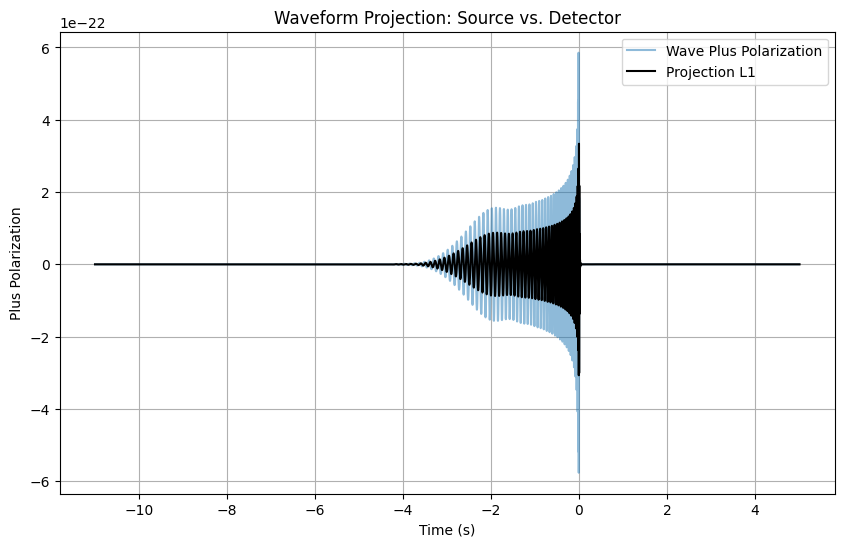

Wave Amplitude:  5.852939591864548e-22
Projected Amplitude: 3.3359832251751195e-22


In [20]:
# generate waveforms using get_td_waveform function
# output is plus and cross polarization created by wave
# plus polarization is the effect of space deformation along x and y axis
# cross polarization is the effect of space deformation along diagonal lines
hplus, hcross = get_td_waveform(approximant="IMRPhenomD",
                                mass1=50, mass2=50, distance=2000,
                                f_lower=min_frequency, delta_t = delta_t)
# Define detector
detector = Detector('L1')

# define random location
right_ascension = random.uniform(0, 2*np.pi)
declination = random.uniform(-np.pi/2, np.pi/2)
polarization = random.uniform(0, 2*np.pi)

# project the generated waveform onto detector using project_wave function
projected_wave = detector.project_wave(hplus, hcross, right_ascension, declination, polarization)

# plot the wave
plt.figure(figsize=(10, 6))
plt.plot(hplus.sample_times, hplus, label='Wave Plus Polarization', alpha=0.5)
plt.plot(projected_wave.sample_times, projected_wave, label='Projection L1', color='black')

plt.title("Waveform Projection: Source vs. Detector")
plt.xlabel("Time (s)")
plt.ylabel("Plus Polarization")
plt.legend()
plt.grid(True)
plt.show()

# define and print absolute max values of wave
wave_max = max(abs(hplus))
projected_max = max(abs(projected_wave))
print(f"Wave Amplitude:  {wave_max}")
print(f"Projected Amplitude: {projected_max}")



**Exercise 2:** From before our detector noise is 20s long. Add the GW into noise after 5s. We also need to get the first 4s to estimate the PSD in the next excercise. Make an overlaid plot with the total data, the portion of data where the GW is added and the data needed to estimate the PSD.

_Bonus:_ Can you also plot the GW signal?


In [29]:
gauss_noise_total = gauss_noise.copy()
recieved_signal = projected_wave.copy()

# starting time
start_time = 5
start = int(start_time / delta_t)

# resize the signal to match the noise size
size = len(gauss_noise_total) - start
recieved_signal.resize(size)

# merge
gauss_noise_total.numpy()[start : start + len(recieved_signal)] += recieved_signal.numpy()

# take first 4 seconds
psd_estimation_portion = gauss_noise_total.time_slice(0, 4)

# portion where gw is added
gw_portion = gauss_noise_total.time_slice(5, 7)

# gw signal
gw_signal = np.zeros(len(gauss_noise_total))
gw_signal[start : start + len(recieved_signal)] = recieved_signal.numpy()


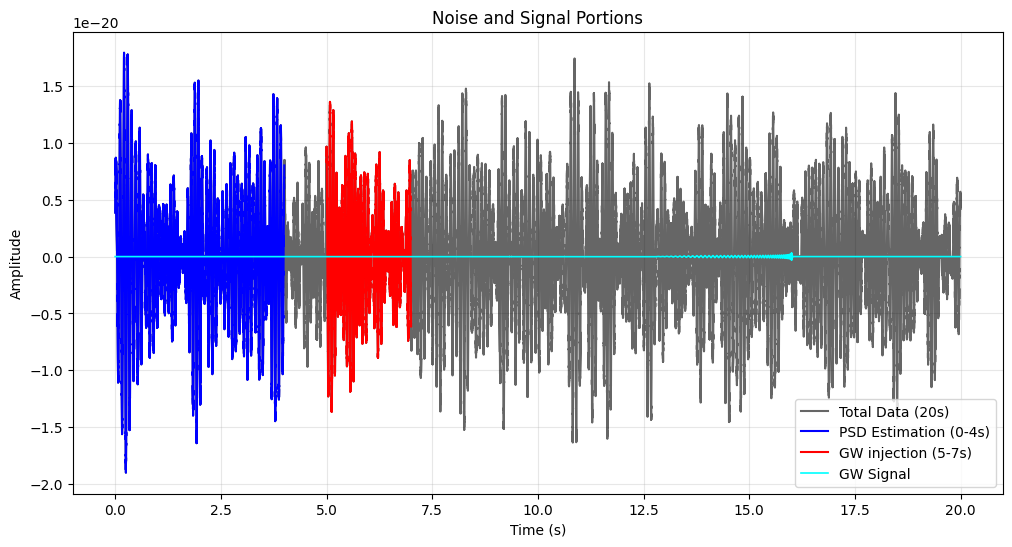

In [36]:
# bonus plot

plt.figure(figsize=(12, 6))

# gauss noise
plt.plot(gauss_noise_total.sample_times, gauss_noise_total,
         label="Total Data (20s)", color='black', alpha=0.6)

# portions
plt.plot(psd_estimation_portion.sample_times, psd_estimation_portion,
         label="PSD Estimation (0-4s)", color='blue')

plt.plot(gw_portion.sample_times, gw_portion,
         label="GW injection (5-7s)", color='red')

plt.plot(gauss_noise_total.sample_times, gw_signal,
         label="GW Signal", color='cyan', linewidth=1.2)

plt.title("Noise and Signal Portions")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Exercise 3:** In a proper search we do not really have the PSD handy. We want to estimate the PSD with Welch's method (see [here](https://ccrma.stanford.edu/~jos/sasp/Welch_s_Method.html) for details), but we want to use the 4s of the beginning where the GW is not present using [this function](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.welch). Plot the estimated PSD. Note that before we used a dummy whitening, and this one is a bit better.

What is the $\Delta_f$ of the estimated PSD? What is $\Delta_f$ of the data we want to whiten to see the GW signal?

_Hint:_ `seg_stride (int)` is usually half of `seg_len`.


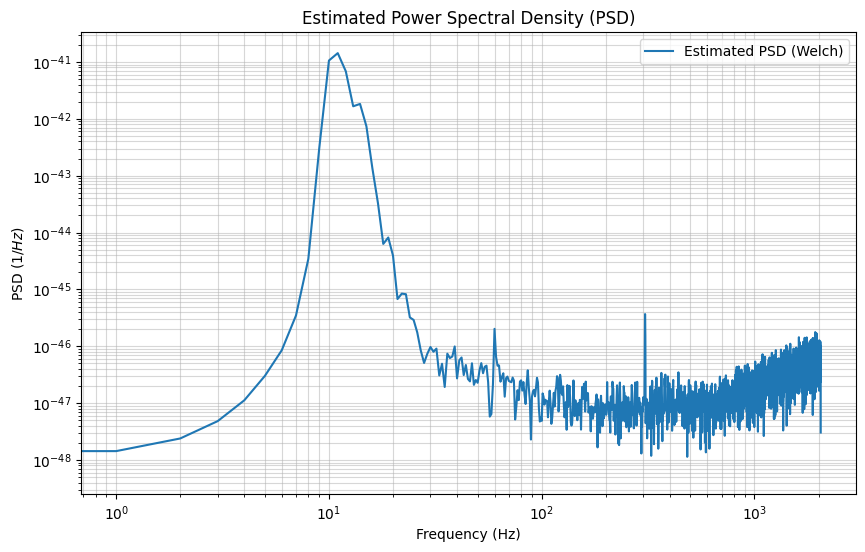

Delta f of the estimated PSD: 1.0 Hz
Delta f of the 20s full data: 0.05 Hz


In [39]:
seg_len = 4096 # sampling rate
seg_stride = 2048 # half of the sampling rate

# Estimate PSD from exercise 2
estimated_psd = pycbc.psd.estimate.welch(psd_estimation_portion,
                                  seg_len=seg_len,
                                  seg_stride=seg_stride,
                                  window='hann',
                                  avg_method='median')

# Plotting the estimated PSD
plt.figure(figsize=(10, 6))
plt.loglog(estimated_psd.sample_frequencies, estimated_psd, label='Estimated PSD (Welch)')
plt.title("Estimated Power Spectral Density (PSD)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD ($1/ Hz$)")
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

# Answering the questions
psd_delta_f = estimated_psd.delta_f
data_delta_f = gauss_noise_total.delta_f

print(f"Delta f of the estimated PSD: {psd_delta_f} Hz")
print(f"Delta f of the 20s full data: {data_delta_f} Hz")

Now that we have the PSD we need to interpolate it to match our data and then limit the filter length of 1 / PSD. After this, we can directly use this PSD to filter the data. Since the data has been highpassed above 12 Hz, and will have low values below this we need to informat the function to not include frequencies below this frequency.

**Exercise 4:** Use the functions [interpolate](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.interpolate) and [inverse_spectrum_truncation](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.inverse_spectrum_truncation) to achieve a proper formatting of the PSD.

_Hint:_ `max_filter_len (int)` is $4 \times$ sampling_rate. Note that the original PSD has a minimum frequency of 12Hz.

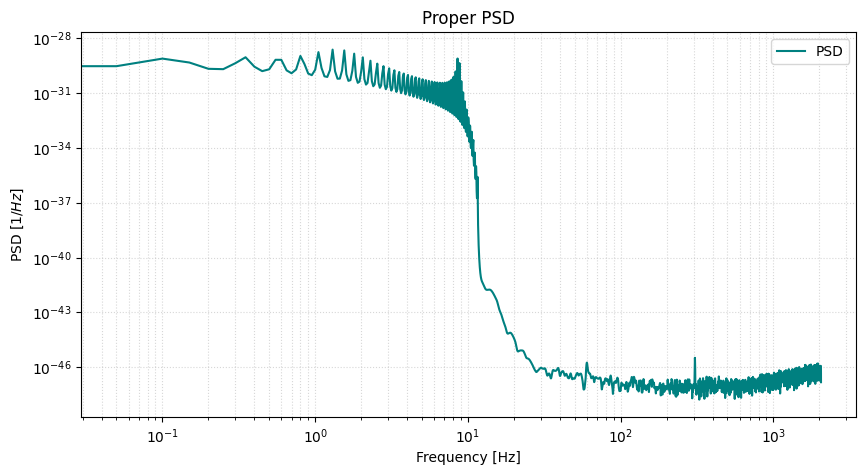

PSD Δf: 0.05 Hz
Data Δf: 0.05 Hz
PSD Length: 40961


In [44]:
# delta f is the same as for the original dataset
new_delta_f = delta_f

# PSD frequency series length is N/2 + 1
psd_length = int((len(gauss_noise_total)/2) + 1)

# Interpolate PSD to new frequency resolution
psd_interpolated = pycbc.psd.estimate.interpolate(estimated_psd,
                         delta_f=new_delta_f,
                         length=psd_length)

# Inverse Spectrum Truncation
# Max Filter lenght is 4x sampling rate
max_filter_len = int(4 / gauss_noise_total.delta_t)

psd_proper = pycbc.psd.estimate.inverse_spectrum_truncation(psd_interpolated,
                                        max_filter_len=max_filter_len,
                                        low_frequency_cutoff=12.0, # minimum frequency of original PSD
                                        trunc_method='hann')

# Plot
plt.figure(figsize=(10, 5))
plt.loglog(psd_proper.sample_frequencies, psd_proper, color='teal', label='PSD')
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [$1/Hz$]")
plt.title("Proper PSD")
plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.show()

print(f"PSD Δf: {psd_proper.delta_f} Hz")
print(f"Data Δf: {gauss_noise_total.delta_f} Hz")
print(f"PSD Length: {len(psd_proper)}")

Now that the PSD is ready, we can whiten the data. Before we used a PyCBC function, but mathematically this is defined as

\begin{equation}
\tilde{d_w}(f) = \tilde{d}(f)/S_{n}^{-1/2}(f)
\end{equation}
where $\tilde{d}$ and $\tilde{d_w}(f)$ are the Fourier transform of the coloured data and whitened data, respectively.

**Exercise 5:** Whiten the data using the interpolated PSD. Crop 5s at the beginning and the end to avoid border effects (_aliasing_) and bandpass it as in the previous exercise. Can you see the GW signal?

/tmp/ipython-input-924091929.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


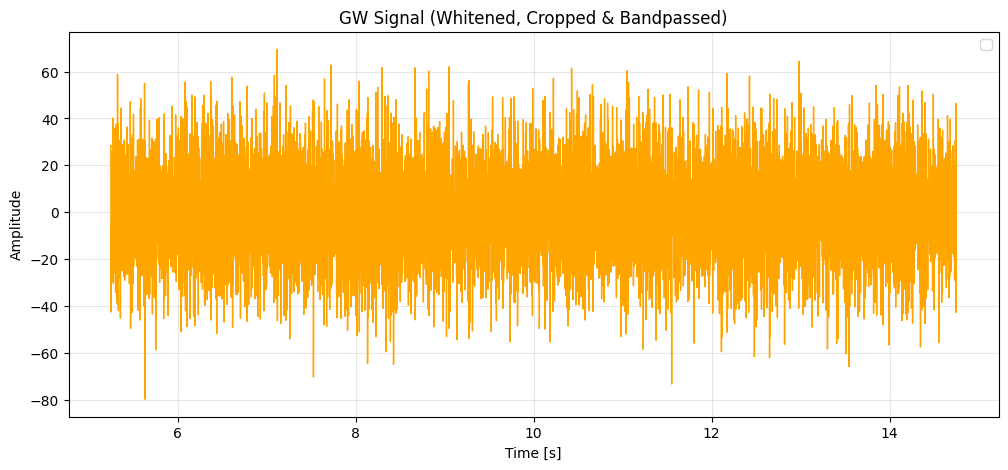

In [52]:
frequency_series = gauss_noise_total.to_frequencyseries()

# whiten the data
white_frequency = frequency_series / (psd_proper**0.5)

# back to time series
white_data = white_frequency.to_timeseries()

# crop 5 sec each side
white_data_cropped = white_data.crop(5, 5)

# Bandpass
white_final = white_data_cropped.highpass_fir(30.0, 512).lowpass_fir(300.0, 512)

# 6. Plotting
plt.figure(figsize=(12, 5))
plt.plot(white_final.sample_times, white_final, color='orange', lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("GW Signal (Whitened, Cropped & Bandpassed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

So far, we buried a GW signal  $h(t)$ in stationary and Gaussian noise $n(t)$ with zero mean, such that $s(t) = h(t) + n(t)$. Given the optimal filter  $K(t)$,

\begin{equation}
\label{eq:filteredsignal}
\hat{s} = \int_{-\infty}^{\infty}  K(t)s(t) dt = \int_{-\infty}^{\infty} \tilde{K}(f)^{*}\tilde{s}(f) df, \quad \text{ where }  \tilde{s}(f) = \int_{-\infty}^{\infty} s(t)e^{-2 \pi i ft}dt
\end{equation}
where $\hat{s}$ is the filtered value of $s(t)$, $^*$ represents the complex conjugate, and $\tilde{\cdot }\ $ the Fourier transform.

The detection statistic that is maximised by the optimal filter $K(t)$  will be the SNR, defined as $\rho = S/N$. $S$ is the expected value of $\hat{s}$ when $h(t) \neq 0$, while $N$ is the squared root of the noise variance when $h(t) =0$. It can be demonstrated that the optimal filter $K(t)$ is the model of the GW signal itself, known as _template_.

The fundamental modelled detection technique is called "matched filtering", since the filter function is chosen to "match" the signal we are looking for. We can write the SNR between an unknown time series $s(t)$ and the template $h_{m}$ as

\begin{equation}
\label{eq:wienerscalar}
\rho =  4 \text{Re} \int_{0}^{\infty} \frac{\tilde{s}^{*}(f)}{S_{n}(f)} \tilde{h_{m}}(f) df.
\end{equation}



**Exercise 6:** Use the [matched_filter](https://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.matchedfilter.matched_filter) function to filter the coloured data with the template. Crop the SNR time series 5s at each side and plot it together with the whitened data. Where is the GW signal? Note that the y-axis of the whitened data is _amplitude_ and the y-axis of the SNR timeseries is _SNR_.

How much is the maximum of the absolute value of the SNR time series? If it is larger than 5 it will generate a "trigger" for further analysis. Will the trigger be generated?

Note that the parameter space of GW signals is vast, so to find these signals, we will need to create a template bank and do this process for thousands of templates. Then, this becomes a high-performance computing problem!

_Hint_: you need to [resize](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.array.Array.resize) the template and use [cyclic_time_shift](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.frequencyseries.FrequencySeries.cyclic_time_shift)

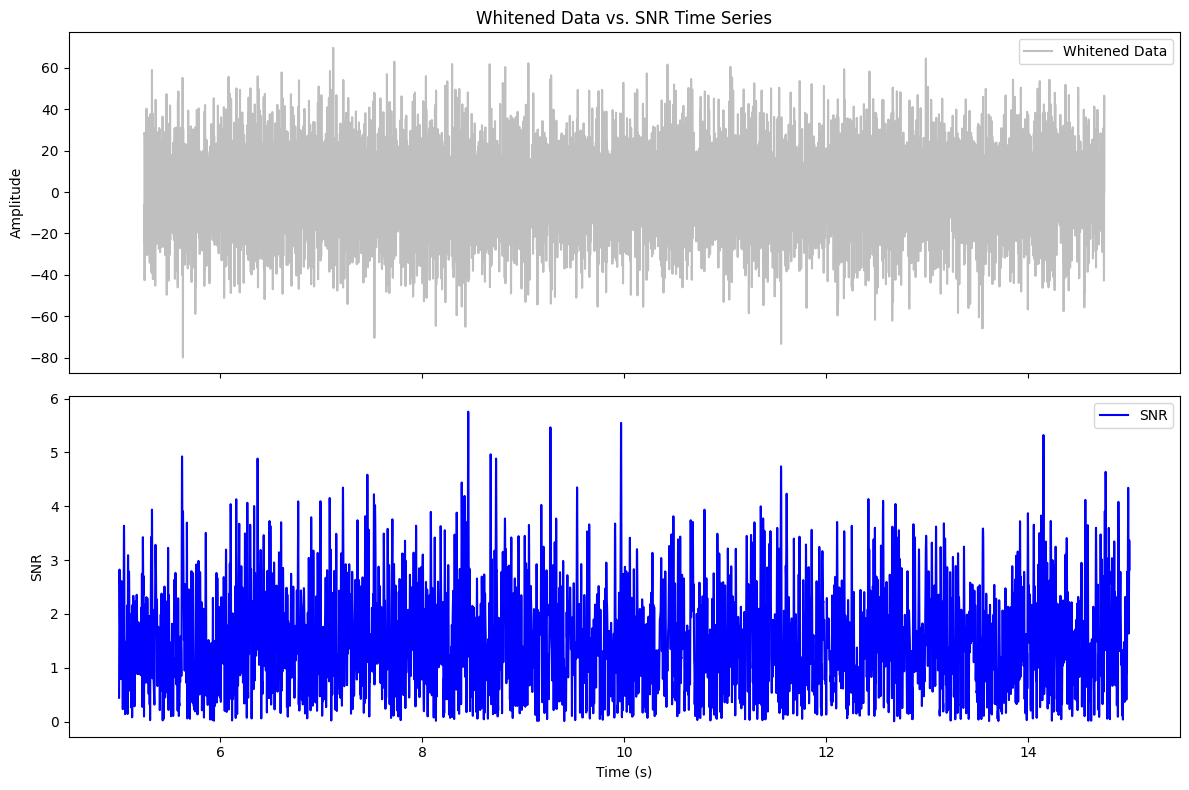

In [53]:
# resize projected wave to size of total gauss noise data
projected_wave.resize(len(gauss_noise_total))

# use cyclic time shift
template = projected_wave.cyclic_time_shift(projected_wave.start_time)

# define SNR
snr_time_series = pycbc.filter.matchedfilter.matched_filter(template, gauss_noise_total,
                     psd=psd_proper, low_frequency_cutoff=30.0)

# Crop 5s from each side
snr_cropped = snr_time_series.crop(5, 5)

# Find the max SNR value
max_snr = max(abs(snr_cropped))

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top Plot: Exercise 5 Data (whitened and bandpassed)
ax1.plot(white_final.sample_times, white_final, color='gray', alpha=0.5, label='Whitened Data')
ax1.set_ylabel("Amplitude")
ax1.set_title("Whitened Data vs. SNR Time Series")
ax1.legend()

# Bottom Plot: SNR Time Series
ax2.plot(snr_cropped.sample_times, abs(snr_cropped), color='blue', label='SNR')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("SNR")
ax2.legend()

plt.tight_layout()
plt.show()

Good job arriving at the end of the tutorial! This was a small peak at GW data analysis that I hope you found interesting.

There is a bonus track exercise if you are bored, but we can also have a chat about some more GW data analysis if you prefer.